# Elastic Metric for Cell Boundary Analysis

## Notebook setup

In [1]:
import os
import subprocess
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
print("Working directory: ", os.getcwd())

import warnings
warnings.filterwarnings("ignore")

import sys
sys_dir = os.path.dirname(os.getcwd()
                          )
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)

INFO: Using numpy backend


Working directory:  /home/wanxinli/dyn
Directory added to path:  /home/wanxinli


## Standard imports

In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## Project-specific imports

In [23]:
import geomstats.datasets.utils as data_utils
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import DiscreteCurves, ClosedDiscreteCurves, L2CurvesMetric

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.pca import TangentPCA


We import the space of curves shapes equipped with different elastic metrics:
- the square root velocity metric (SRV), which is the canonical elastic metrics,
- the generalized elastic metric with parameters a, b.

# Load the dataset of interest

We load an experimental cell dataset with `n_cells` and `n_sampling_points` sampled along the boundary of each cell. 

For faster notebook execution, use small value for `n_cells` and `n_sampling_points`.

In [5]:
dataset_name = "osteosarcoma"  # "osteosarcoma" #  "retinal"
# dataset_name = "retinal"
assert dataset_name in ["osteosarcoma", "retinal"]
cell_type = "dunn"
all_cell_types = ["dunn", "dlm8"]

if dataset_name == "osteosarcoma":
    n_cells = 650
    n_sampling_points = 100
    lines_name = "lines"
    treatments_name = "mutations"

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)
LINES = gs.unique(lines)
print(LINES)

SAVEFIG = True
if SAVEFIG:
    figs_dir = os.path.join(os.getcwd(), f"dyn/saved_figs/{dataset_name}")
    print(f"Will save figs to {figs_dir}")
    from datetime import datetime

    now = datetime.now().strftime("%Y%m%d_%H:%M:%S")
    print(now)

Total number of cells : 650
['control' 'cytd' 'jasp']
['dlm8' 'dunn']
Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma
20230514_03:04:40


In [6]:
ds = {}

n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

display(n_cells_df)
# display(ds)

control :
	 114 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


,dlm8,dunn
control,114.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


The variable `quotient` is used to define what is called a `cell_shape`.
- `cells`: has only removed the effect of the translation
- `cell_shapes`: additionally removes what is written in `quotient`: the effect of the scaling, and of the rotation.

Note: in the previous analysis, we were using the linear euclidean metric on cells (without translation), and the srv metric on cell shapes (without translation, scaling and rotation).

This notebook compares the linear versus the srv metric on data on which the same preprocessing has been performed.

In [7]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


k_sampling_points = 200

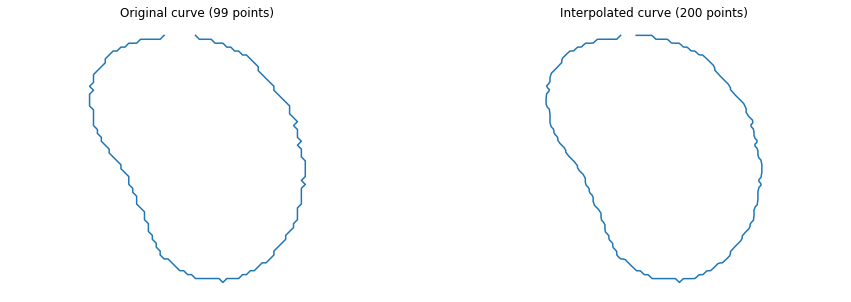

In [8]:
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

In [9]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

In [10]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

In [11]:
print(ds_interp["control"]["dunn"].shape)

(204, 200, 2)


In [12]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

In [13]:
from geomstats.geometry.pre_shape import PreShapeSpace

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=k_sampling_points)

PRESHAPE_SPACE.equip_with_group_action("rotations")
PRESHAPE_SPACE.equip_with_quotient_structure()


def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.fiber_bundle.align(point=gs.array(reparametrized), base_point=base_curve)
        distances[shift] = PRESHAPE_SPACE.embedding_space.metric.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.fiber_bundle.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )
    return aligned_curve

In [14]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

ds_proj = apply_func_to_ds(ds_proc, func=PRESHAPE_SPACE.projection)
print(ds_proj["control"]["dunn"].shape)

BASE_CURVE = ds_proj["control"]["dunn"][0]
print("Shape of BASE_CURVE:", BASE_CURVE.shape)

ds_align = apply_func_to_ds(ds_proj, func=lambda x: exhaustive_align(x, BASE_CURVE))
print(ds_align["control"]["dunn"].shape)

(204, 200, 2)
Shape of BASE_CURVE: (200, 2)
(204, 200, 2)


In [15]:
cell_shapes_list = []
for treatment in TREATMENTS:
    for line in LINES:
        cell_shapes_list.extend(ds_align[treatment][line])

cell_shapes = gs.array(cell_shapes_list)
print(cell_shapes.shape)

(650, 200, 2)


# Preprocessing

# Remove the cell of the other type


In [16]:
def remove_cells(cells, cell_shapes, lines, treatments, delete_indices):
    """ 
    Remove cells of control group from cells, cell_shapes, lines, treatments,
    the parameters returned from load_treated_osteosarcoma_cells
    Also update n_cells

    :param list[int] delete_indices: the indices to delete
    """
    
    # Delete elements
    cells = np.delete(np.array(cells), delete_indices, axis=0)
    cell_shapes = np.delete(np.array(cell_shapes), delete_indices, axis=0)
    lines = list(np.delete(np.array(lines), delete_indices, axis=0))
    treatments = list(np.delete(np.array(treatments), delete_indices, axis=0))
    global n_cells
    n_cells = cells.shape[0]

    return cells, cell_shapes, lines, treatments

In [17]:
# Find all cells of the other type
remove_indices = []
remove_cell_type = copy.deepcopy(all_cell_types)
remove_cell_type.remove(cell_type)
remove_cell_type = remove_cell_type[0]
for i in range(len(lines)):
    if lines[i] == remove_cell_type:
        remove_indices.append(i)

# Delete all cells of the other type
cells, cell_shapes, lines, treatments = remove_cells(cells, cell_shapes, lines, treatments, remove_indices)

## Remove outliers by DeCOr-MDS using linear metric

In [9]:
from nsimplices import *
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric

# Prepare functions for calculating pairwise distances
def srv_dist(cell1, cell2):
    return SRV_METRIC.dist(cell1, cell2) / n_sampling_points

@jit(nopython=False, forceobj=True)
def parallel_dist(cells, dist_fun):
    pairwise_dists = np.zeros((n_cells, n_cells))
    for i in prange(n_cells):
        for j in prange(i + 1, n_cells):
            pairwise_dists[i, j] = dist_fun(cells[i], cells[j]) / n_sampling_points
    pairwise_dists += pairwise_dists.T
    return pairwise_dists

In [10]:
# compute pairwise distances
pairwise_dists = parallel_dist(cell_shapes, dist_fun=srv_dist)

# run DeCOr-MDS
dim_start = 2
dim_end = 2
feature_num = 2
outlier_indices, subspace_dim , corr_pairwise_dis, corr_coord = nsimplices(pairwise_dists, feature_num, dim_start, dim_end, std_multi=2)


INFO: finding looplift candidates


In [11]:
# Find indices for cells that are dlm8
print("outlier_indices are:", outlier_indices)

outlier_indices are: [ 89 204 205 206 208 210 211 213 214 215 216 222 224 225 226 229 230 231
 232 234 235 238 239 240 241 245 246 247 249 250 253 256 257 262 265 266
 267 268 269 270 271 272 274 275 277 278 284 286 287 288 290 291 293 294
 295 296]


In [12]:
print("cells shape is:", cells.shape)
print("cell_shapes shape is:", cell_shapes.shape)
print("lines shape is:", len(lines))
print("treatments shape is:", len(treatments))
print("n_cells is:", n_cells)

cells shape is: (392, 100, 2)
cell_shapes shape is: (392, 100, 2)
labels_a shape is: 392
labels_b shape is: 392
n_cells is: 392


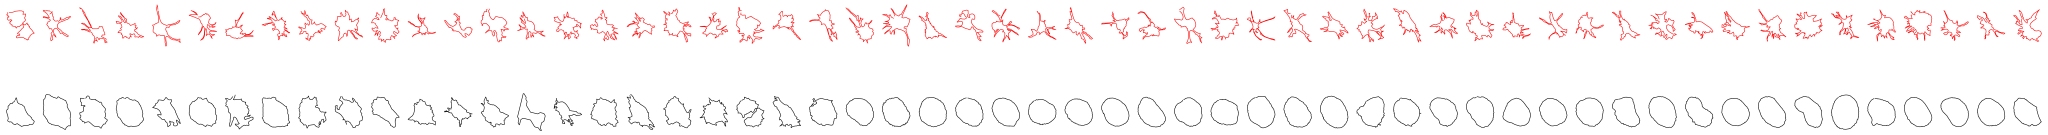

<Figure size 432x288 with 0 Axes>

In [13]:
# plot the some outlier cells and some normal cells

normal_indices=[i for i in range(pairwise_dists.shape[0]) if i not in outlier_indices] # list of normal points 

fig = plt.figure(figsize=(100, 8))
nrows = 2
ncols = len(outlier_indices) 

# plot outlier cells
for i in range(ncols):
    outlier_index = outlier_indices[i]
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.plot(cell_shapes[outlier_index, :, 0], cell_shapes[outlier_index, :, 1], "red")
    ax.set_aspect("equal")
    ax.axis("off")
    

# plot normal cells
for i in range(ncols):
    normal_index = normal_indices[i]
    ax = fig.add_subplot(nrows, ncols, i+1+ncols)
    ax.plot(cell_shapes[normal_index, :, 0], cell_shapes[normal_index, :, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")

plt.show()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_{cell_type}_normal_outlier.svg"))

# TODO: (A) raw image (B) (C) below


In [18]:
""" 
Only remove abnormal cells
"""
if cell_type == "dunn":
    abnormal_outlier_indices = [89]
    cells, cell_shapes, lines, treatments = remove_cells(cells, cell_shapes, lines, treatments, abnormal_outlier_indices)

In [19]:
lines_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(lines))}
treatments_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(treatments))}

print(f"Dictionary associated to label \"{lines_name}\":")
print(lines_dict)
print(f"Dictionary associated to label \"{treatments_name}\":")
print(treatments_dict)

Dictionary associated to label "lines":
{'dunn': 0}
Dictionary associated to label "mutations":
{'control': 0, 'cytd': 1, 'jasp': 2}


## Define Shape Spaces

In [24]:
R2 = Euclidean(dim=2)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE_SRV = DiscreteCurves(R2, k_sampling_points=200)

SRV_METRIC = CURVES_SPACE_SRV.metric

ELASTIC_METRIC = {}
METRICS = {}
METRICS["Linear"] = L2CurvesMetric
METRICS["SRV"] = SRV_METRIC

here
here


# Sample Means

We compare results when computing the mean cell versus the mean cell shapes with different elastic metrics.

In [43]:
means = {}

means["Linear"] = gs.mean(cell_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes).estimate_

# Distances to the mean(s)

We compute the distances between:
- every cell in the dataset
- and the mean cell shape, according to the different metrics: Euclidean (Linear), SRV and Elastic Metrics.

In [26]:
R2 = Euclidean(dim=2)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE_SRV = DiscreteCurves(R2, k_sampling_points=200)
SRV_METRIC = CURVES_SPACE_SRV.metric

ELASTIC_METRIC = {}
METRICS = {}
METRICS["Linear"] = L2CurvesMetric
METRICS["SRV"] = SRV_METRIC

here
here


In [27]:
means = {}

means["Linear"] = gs.mean(cell_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes).estimate_

In [32]:
print(means["Linear"].shape)
print(cells[0].shape)

(200, 2)
(113, 2)


In [37]:
dists = {}

dists["Linear"] = [gs.linalg.norm(means["Linear"] - cell) / n_sampling_points for cell in cell_shapes]

dists["SRV"] = [
    SRV_METRIC.dist(means["SRV"], cell) / n_sampling_points for cell in cell_shapes
]

In [39]:
dists_summary = pd.DataFrame(
    data={
        lines_name: lines,
        treatments_name: treatments,
        "Linear": dists["Linear"],
        "SRV": dists["SRV"],
    }
)

In [40]:
dists_summary.head()

,lines,mutations,Linear,SRV
0,dunn,control,0.001144,0.004242
1,dunn,control,0.001390,0.004319
2,dunn,control,0.002194,0.005906
3,dunn,control,0.001118,0.003754
4,dunn,control,0.002810,0.007085


# Quantiles of distribution of distances to the mean(s)

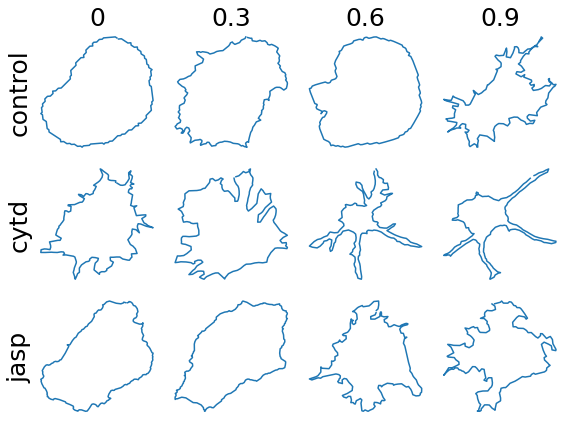

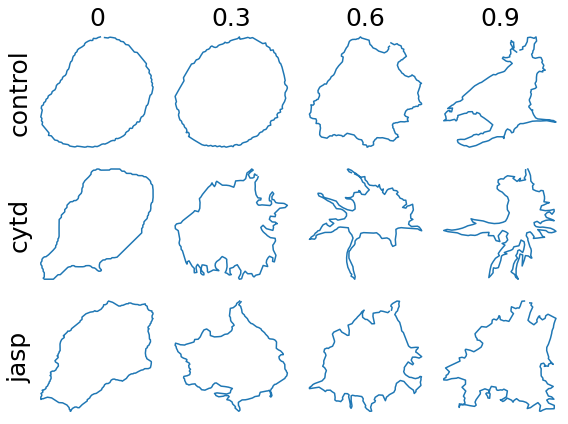

In [42]:
for dist_name in ["Linear", "SRV"]:
    quantiles = [0, 0.3, 0.6, 0.9]
    fig, axes = plt.subplots(
        nrows=len(lines_dict) * len(treatments_dict),
        ncols=len(quantiles),
        figsize=(8, 2 * len(lines_dict) * len(treatments_dict)),
    )

    for i_lab_b, label_b in enumerate(np.unique(treatments)):
        for j_lab_a, label_a in enumerate(np.unique(lines)):
            dists_list = dists_summary[dist_name][
                        dists_summary[lines_name] == label_a][dists_summary[treatments_name] == label_b]
            # The following line ennsures that all values of distances are different, 
            # which is required in order to use the function "sorted" later
            dists_list = [d + 0.000001 * gs.random.rand(1)[0] for d in dists_list]
            cells_list = [cell for cell, lab_a, lab_b in zip(cell_shapes, lines, treatments) if lab_a == label_a and lab_b == label_b]
            assert len(dists_list) == len(dists_list)
            n_cells = len(dists_list)

            zipped_lists = zip(dists_list, cells_list)
            sorted_pairs = sorted(zipped_lists)

            tuples = zip(*sorted_pairs)
            sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
            for i, cur_quantile in enumerate(quantiles):
                quantile = int(n_cells * cur_quantile)
                one_cell = sorted_cells_list[quantile]
                ax = axes[len(np.unique(lines)) * i_lab_b + j_lab_a, i]
                ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j_lab_a}")
                if i_lab_b == 0:
                    ax.set_title(f"{cur_quantile}", fontsize=25)
                # Turn off tick labels
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.spines["bottom"].set_visible(False)
                ax.spines["left"].set_visible(False)
                if cur_quantile == 0:
                    ax.set_ylabel(f"{label_b}", rotation=90, fontsize=25)
    plt.tight_layout()
    # plt.suptitle(f"Quantiles for {dist_name} Metric", y=-0.01, fontsize=24)
    if SAVEFIG:
        plt.savefig(os.path.join(figs_dir, f"{now}_{cell_type}_quantiles_{dist_name}.pdf"))